# Import Libraries

In [159]:
# import libraries
import pandas as pd
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
from sklearn.linear_model import LinearRegression
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge, LinearRegression,RidgeCV,LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# API call to get  movies data 

In [3]:
# page from 1 to 49
num=list(range(1,500))

In [4]:
# create Funtion to get each page data 
def get_site(num):
    html =' https://api.themoviedb.org/3/movie/top_rated?api_key=*************&language=en-US&page={}'.format(num)
    r = requests.get(html)  
    return r.json()

In [5]:
#loop each page to collect 49 pages top-rate movie data
movies=[]
for i in num:
    movies.append(get_site(i))

In [6]:
#check the length of the data
len(movies)

999

In [12]:
# Save data using pickle
# pickle_out=open('movies', 'wb')
# pickle.dump(movies, pickle_out)
# pickle_out.close()
pickle_in_data = open("movies","rb")
movies = pickle.load(pickle_in_data)

In [38]:
# total pages are upto 359
movie_list = movies[:359]

In [79]:
movie_result=[]
for page in movie_list:
    movie_result.extend(page['results'])

In [745]:
#convert jason data into dataframe using pandas 
movie_df1=pd.DataFrame(movie_result).drop(columns=['poster_path','backdrop_path','original_title'])

# movie_id to collect movie genres/budget/imdb_id

In [101]:
# create a funtion using movie_id to collect movie genres/budget/imdb_id
def movie_information(num):
    html ='https://api.themoviedb.org/3/movie/{}?api_key=***********&language=en-US'.format(num)
    r = requests.get(html)  
    return r.json()

In [102]:
#get top rate movies id and budget/revenue/production_companies/runtime
#/"runtime"/,"vote_average"/ "vote_count"
movies_df2=[]
for i in movie_df1['id']:
    movies_df2.append(movie_information(i))

In [103]:
# pickle_out=open('movies_df2', 'wb')
# pickle.dump(movies_df2, pickle_out)
# pickle_out.close()

In [10]:
pickle_in_data = open("movies_df2","rb")
movies_df2 = pickle.load(pickle_in_data)

In [11]:
# select features I need  to analyze
features=['id','budget','vote_average', 'vote_count', 'original_language',
       'overview', 'popularity','release_date', 'revenue', 'runtime',
         'tagline', 'title', 
       'genres','production_companies','production_countries' ]

movie=pd.DataFrame(movies_df2)[features]

In [12]:
# re-arrage the column of genres 
genres=[]
for row in movie['genres']:
    genres.append([i['name'] for i in row])
# double check the length
len(genres)

7175

In [13]:
# re-arrage the column of production_companies
production_companies=[]
for row in movie.production_companies:
    production_companies.append([i['name'] for i in row])
len(production_companies)# double check the length

7175

In [14]:
# re-arrage the column of production_countries
production_countries=[]
for row in movie.production_countries:
    production_countries.append([i['iso_3166_1'] for i in row])
len(production_companies)# double check the length

7175

In [15]:
# replace all corresponding columns with new columns above 
movie['genres']=genres
movie['production_companies']=production_companies
movie['production_countries']=production_countries

In [16]:
# obtian unique genres
from itertools import chain
unique_genres = list(set(list(chain(*genres))))
# Create new columns  for unique_genres,unique_companies,unique_countries
for genre in unique_genres:
    movie[genre]=0

In [17]:
# #create dummy variable
for i in range(len(movie['genres'])) :
    for genre in unique_genres:
        if genre in movie['genres'][i]:
            movie[genre][i]=1

/Users/yingyuxuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [18]:
#check what kind of data it contains
movie.columns

Index(['id', 'budget', 'vote_average', 'vote_count', 'original_language',
       'overview', 'popularity', 'release_date', 'revenue', 'runtime',
       'tagline', 'title', 'genres', 'production_companies',
       'production_countries', 'Fantasy', 'Animation', 'History', 'Comedy',
       'Family', 'TV Movie', 'Western', 'Adventure', 'War', 'Romance',
       'Thriller', 'Horror', 'Music', 'Science Fiction', 'Crime', 'Action',
       'Drama', 'Mystery'],
      dtype='object')

# Get the keywords data

In [19]:
#create a funtion to get the keywords for each movie ID
def Get_Keywords(num):
    link1='https://api.themoviedb.org/3/movie/{}/keywords?api_key=********'.format(num)
    return requests.get(link1).json()

In [20]:
#loop the movie ID with the funtion above to get all movieIDs' keywords
keywords_list=[]
for i in movie['id']:
    keywords_list.append(Get_Keywords(i))

In [21]:
list_keywords=keywords_list.copy()

In [22]:
keywords=[]
for j in range(len(list_keywords)):
    keywords.append([i['name'] for i in list_keywords[j]['keywords']])

In [23]:
# add keywords in the movie dataframe
movie['keywords']=keywords

In [24]:
movie.head()

,id,budget,vote_average,vote_count,original_language,overview,popularity,release_date,revenue,runtime,...,Romance,Thriller,Horror,Music,Science Fiction,Crime,Action,Drama,Mystery,keywords
0,537061,0,8.8,222,en,"Two years after the events of ""Change Your Min...",26.039,2019-09-02,0,82.0,...,0,0,0,1,1,0,0,0,0,[movie of the year]
1,640344,75000,8.8,205,it,Luì and Sofì fight the terrible Signor S once ...,8.979,2020-01-17,0,0.0,...,0,0,0,0,0,0,0,0,0,[]
2,19404,13200000,8.8,2248,hi,"Raj is a rich, carefree, happy-go-lucky second...",26.530,1995-10-20,100000000,190.0,...,1,0,0,0,0,0,0,1,0,[]
3,278,25000000,8.7,15795,en,Framed in the 1940s for the double murder of h...,55.366,1994-09-23,28341469,142.0,...,0,0,0,0,0,1,0,1,0,"[prison, corruption, police brutality, prison ..."
4,238,6000000,8.7,11988,en,"Spanning the years 1945 to 1955, a chronicle o...",41.161,1972-03-14,245066411,175.0,...,0,0,0,0,0,1,0,1,0,"[italy, loss of loved one, love at first sight..."


# Get the Cast Data

In [25]:
#cast
def Get_Cast(num):
    link2='https://api.themoviedb.org/3/movie/{}/credits?api_key=*************'.format(num)
    return requests.get(link2).json()

In [26]:
# to get the cast data
cast_list=[]
for i in movie['id']:
    cast_list.append(Get_Cast(i))

In [27]:
cast=[]
for i in range(len(cast_list)):
    cast.append([i['name'] for i in cast_list[i]['cast']])   

In [28]:
movie['cast']=cast

In [29]:
# obtian directors information 
director=[]
for j in range(len(cast_list)):
    director.append([i['name'] for i in cast_list[j]['crew'] if i['job']=='Director'])

In [30]:
movie['director']=director

In [31]:
import datetime
movie.release_date=pd.to_datetime(movie.release_date)

In [32]:
# gross
gross=movie.revenue-movie.budget
movie['gross']=gross

In [33]:
movie.head()

,id,budget,vote_average,vote_count,original_language,overview,popularity,release_date,revenue,runtime,...,Music,Science Fiction,Crime,Action,Drama,Mystery,keywords,cast,director,gross
0,537061,0,8.8,222,en,"Two years after the events of ""Change Your Min...",26.039,2019-09-02,0,82.0,...,1,1,0,0,0,0,[movie of the year],"[Zach Callison, Estelle, Deedee Magno, Michael...",[Rebecca Sugar],0
1,640344,75000,8.8,205,it,Luì and Sofì fight the terrible Signor S once ...,8.979,2020-01-17,0,0.0,...,0,0,0,0,0,0,[],"[Sofia Scalia, Luigi Calagna, Antonella Carone...",[Gianluca Leuzzi],-75000
2,19404,13200000,8.8,2248,hi,"Raj is a rich, carefree, happy-go-lucky second...",26.530,1995-10-20,100000000,190.0,...,0,0,0,0,1,0,[],"[Shah Rukh Khan, Kajol, Amrish Puri, Anupam Kh...",[Aditya Chopra],86800000
3,278,25000000,8.7,15795,en,Framed in the 1940s for the double murder of h...,55.366,1994-09-23,28341469,142.0,...,0,0,1,0,1,0,"[prison, corruption, police brutality, prison ...","[Tim Robbins, Morgan Freeman, Bob Gunton, Clan...",[Frank Darabont],3341469
4,238,6000000,8.7,11988,en,"Spanning the years 1945 to 1955, a chronicle o...",41.161,1972-03-14,245066411,175.0,...,0,0,1,0,1,0,"[italy, loss of loved one, love at first sight...","[Marlon Brando, Al Pacino, James Caan, Richard...",[Francis Ford Coppola],239066411


In [34]:
movie.to_csv('movie.csv')

# EDA

##  Gross VS popularity

In [768]:
rp=movie[['gross','popularity']].sort_values(by='popularity',ascending=False).reset_index().drop(columns='index')
rp.head()

,gross,popularity
0,39675922,615.719
1,-39117072,219.471
2,180493652,192.249
3,191150000,183.757
4,823604458,176.679


In [769]:
#seperate revenue into four levels with different quantiles
rp_y=[gp.iloc[720:]['gross'].mean(),gp.iloc[480:720]['gross'].mean(),
      gp.iloc[240:480]['gross'].mean(),gp.iloc[:240]['gross'].mean()]

In [770]:
# label names
rp_x=['level 1','level 2','level 3','level 4']

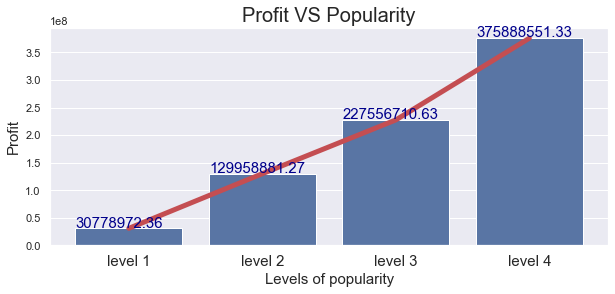

In [771]:
# plot the polularity with different revenue levels
plt.figure(figsize=(10,4))

sns.barplot(rp_x,rp_y,color='b')
sns.lineplot(rp_x,rp_y,linewidth=5,color='r')
plt.title('Profit VS Popularity',fontsize=20)
plt.ylabel('Profit',fontsize=15)
plt.xlabel('Levels of popularity',fontsize=15)
plt.xticks(fontsize=15)

r = list(range(0,4))

label = rp_y

for i in range(len(r)):
    plt.text(x = r[i]-0.4 , y = label[i]+2000000, s = round(label[i],2), size = 15,color='darkblue')
plt.show()

## movie populairty changes by year

In [465]:
movie['month']=movie['release_date'].dt.month 
movie['year']=movie['release_date'].dt.year

In [483]:
import plotly.express as px
import plotly.graph_objects as go
# groupby year and obtian the mean of popularity 
year_pop=movie.groupby(['year'])['popularity'].mean().reset_index()
# plot the trend
fig = px.line(x=year_pop['year'], y=year_pop['popularity'], title="Trend of Movie's Populairty in One Century")
fig.show()


## Profit VS Vote_average

In [488]:
rv=movie[['vote_average','gross']].sort_values(by='vote_average',ascending=False).reset_index().drop(columns='index')

#seperate revenue into four levels with different quantiles
rv_y=[rv.iloc[720:]['gross'].mean(),rv.iloc[480:720]['gross'].mean(),
      rv.iloc[240:480]['gross'].mean(),rv.iloc[:240]['gross'].mean()]
# labels for x axis 
rv_x=['level 1','level 2','level 3','level 4']

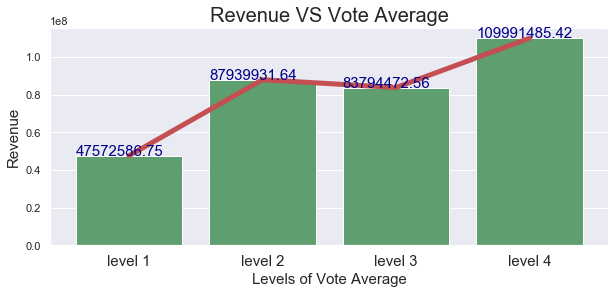

In [489]:
plt.figure(figsize=(10,4))
sns.barplot(rv_x,rv_y,color='g')
sns.lineplot(rv_x,rv_y,linewidth=5,color='r')
plt.title('Revenue VS Vote Average',fontsize=20)
plt.ylabel('Revenue',fontsize=15)
plt.xlabel('Levels of Vote Average',fontsize=15)
plt.xticks(fontsize=15)

r = list(range(0,4))

label = rv_y

for i in range(len(r)):
    plt.text(x = r[i]-0.4 , y = label[i]+100000, s = round(label[i],2), fontsize =15,color='darkblue')



plt.show()

#plt.xlabel('Levels of vote_average',fontsize=20)

## profit VS runtime

we can see that in different levels of vote average the revenue does have big differences between different levels

In [490]:
rev_run=movie[['gross','runtime']].sort_values(by='runtime',ascending=False).reset_index()

rr_y=[rev_run.iloc[720:]['gross'].mean(),rev_run.iloc[480:720]['gross'].mean(),
      rev_run.iloc[240:480]['gross'].mean(),rev_run.iloc[:240]['gross'].mean()]

rr_x=['level 1','level 2','level 3','level 4']

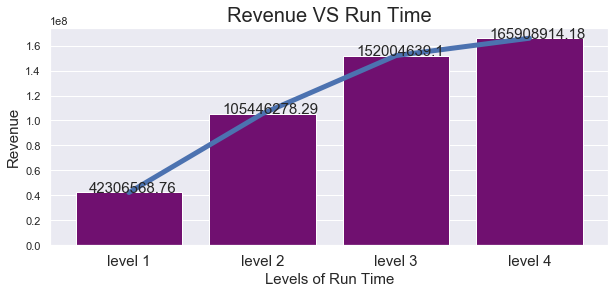

In [491]:
plt.figure(figsize=(10,4))

sns.barplot(rr_x,rr_y,color='purple')
sns.lineplot(rr_x,rr_y,linewidth=5,color='b')
plt.title('Revenue VS Run Time',fontsize=20)
plt.ylabel('Revenue',fontsize=15)
plt.xlabel('Levels of Run Time',fontsize=15)
plt.xticks(fontsize=15)

r = list(range(0,4))

label = rr_y

for i in range(len(r)):
    plt.text(x = r[i]-0.3 , y = label[i]+1, s = round(label[i],2), fontsize = 15)
plt.show()

## Top 50 popular cast, directors,genres

In [546]:
#  function for count the word frequency and orderd them by high to low frequency
def counter(column):
    list1= list(chain(*column))
    dict1={}
    for i in list1:
        dict1[i]=list1.count(i)
    dict2={k: v for k, v in sorted(dict1.items(), key=lambda item: item[1],reverse=True)}
    return dict2

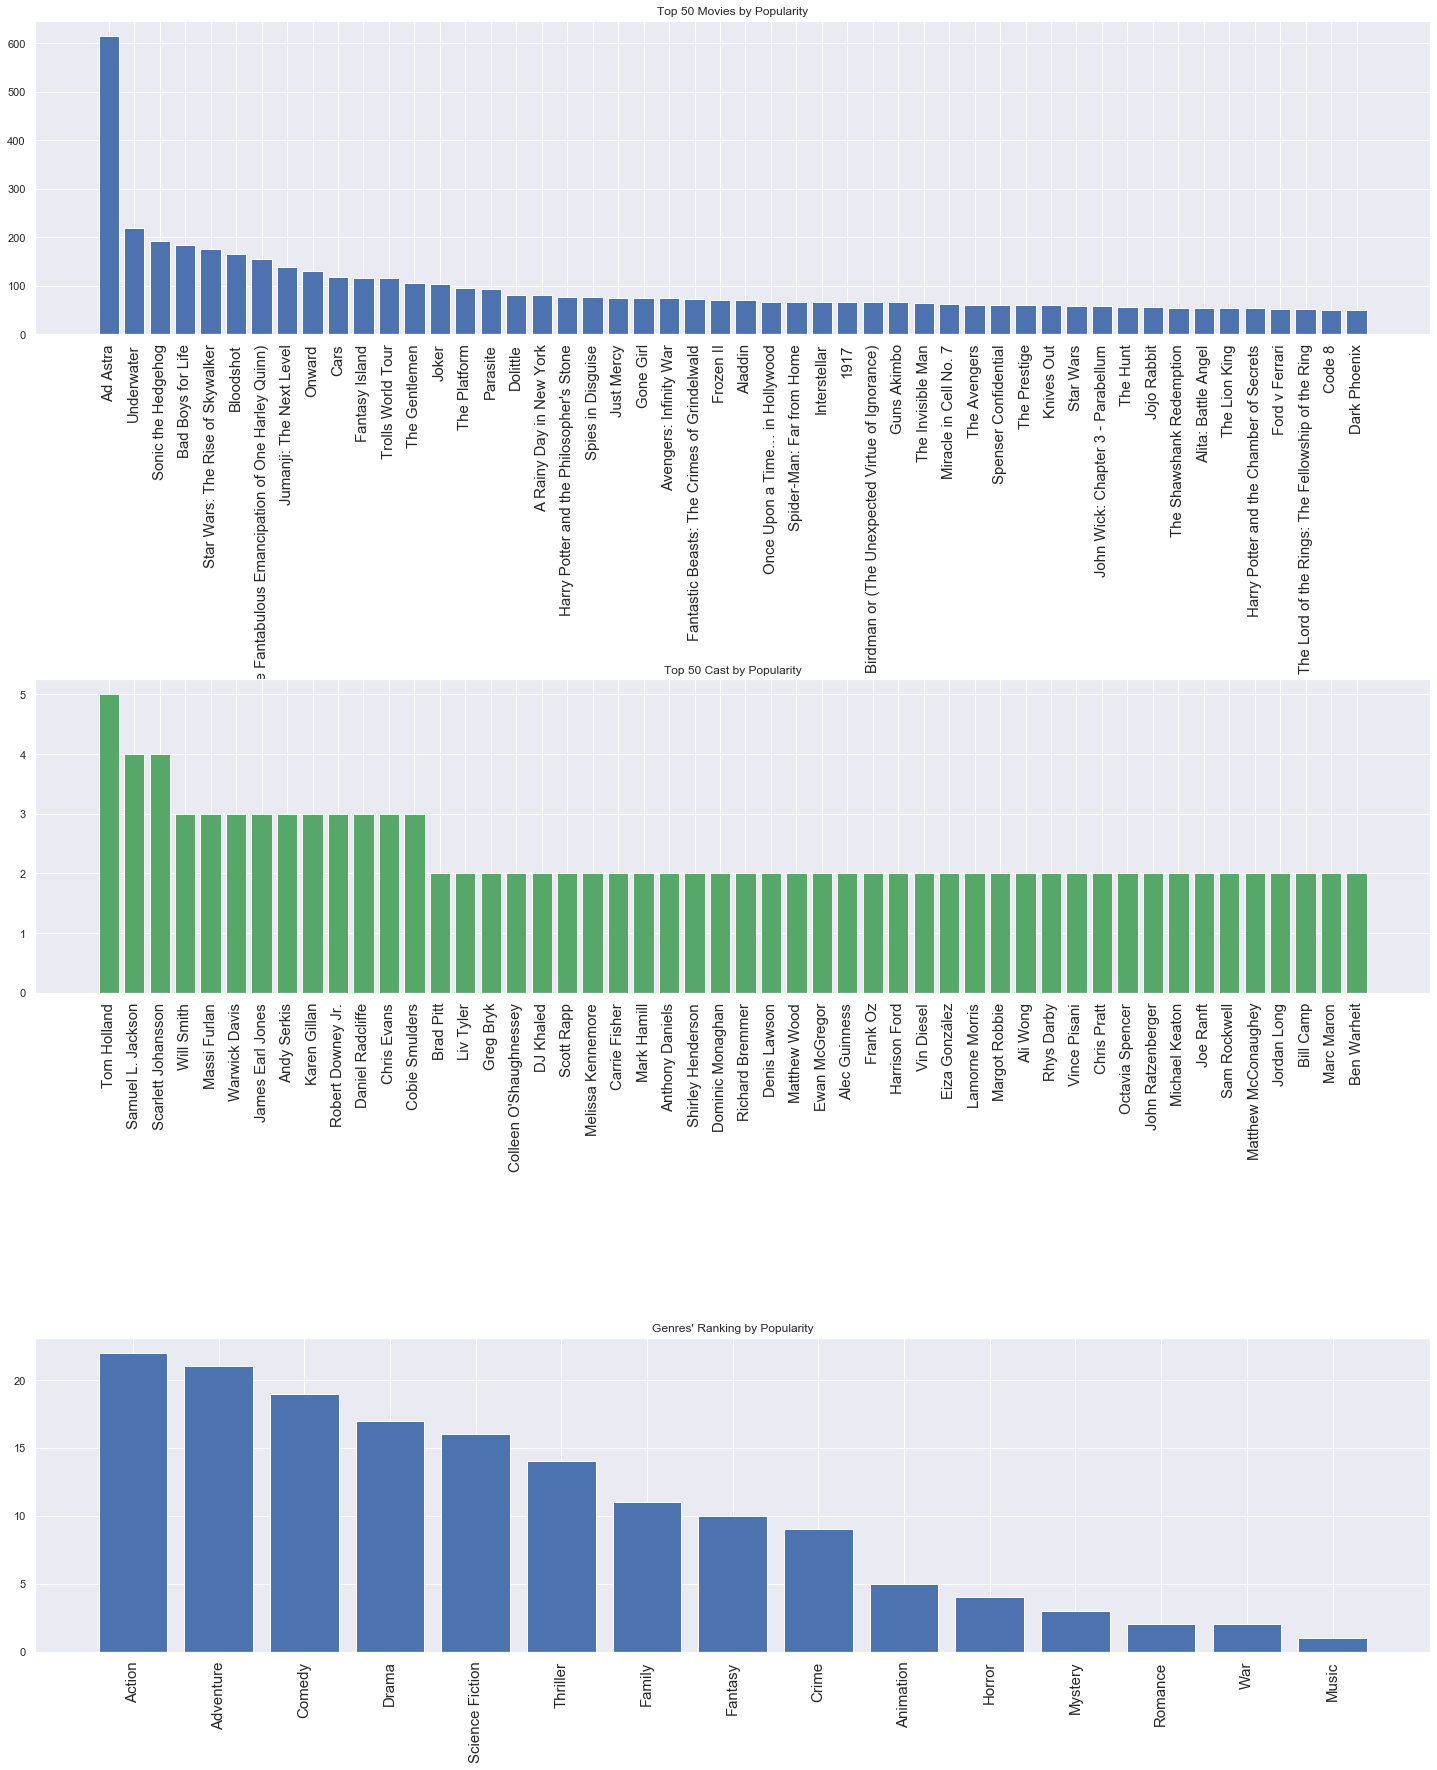

In [663]:
## top 50 Casts ,Directors, Genres by Popularity and Check frequency for each of them 
top_50_popular=movie[['title','cast','director','genres','popularity']].sort_values(by='popularity',ascending=False).reset_index().drop(columns='index').head(50)

top_50_popular_cast=counter(top_50_profit.cast)
top_50_popular_dir=counter(top_50_profit.director)
top_50_popular_gen=counter(top_50_profit.genres)


# plot 
plt.figure(figsize=(25,30))

plt.subplot(3,1,1)
plt.bar(top_50_popular.title,top_50_popular.popularity,color='b')
plt.xticks(rotation=90,size=15)
plt.title('Top 50 Movies by Popularity')

plt.subplot(3,1,2)
#plt.subplots_adjust(hspace=6)
cast_dict=[{key:value} for key,value in top_50_popular_cast.items() if value>=2]
plt.bar(list(top_50_popular_cast.keys())[:50],list(top_50_popular_cast.values())[:50],color='g')
plt.xticks(rotation=90,size=15)
plt.title('Top 50 Cast by Popularity')

plt.subplot(3,1,3)

plt.bar(top_50_popular_gen.keys(),top_50_popular_gen.values(),color='b')
plt.xticks(rotation=90,size=15)
plt.title("Genres' Ranking by Popularity")
plt.subplots_adjust(hspace=1.1)
plt.show()

In [669]:
top_50_popular_dir=[i[0] for i in top_50_popular.director]
top_50_popular_dir

['James Gray',
 'William Eubank',
 'Jeff Fowler',
 'Adil El Arbi',
 'J.J. Abrams',
 'Dave Wilson',
 'Cathy Yan',
 'Jake Kasdan',
 'Dan Scanlon',
 'John Lasseter',
 'Jeff Wadlow',
 'Walt Dohrn',
 'Guy Ritchie',
 'Todd Phillips',
 'Galder Gaztelu-Urrutia',
 'Bong Joon-ho',
 'Stephen Gaghan',
 'Woody Allen',
 'Chris Columbus',
 'Troy Quane',
 'Destin Daniel Cretton',
 'David Fincher',
 'Anthony Russo',
 'David Yates',
 'Chris Buck',
 'Guy Ritchie',
 'Quentin Tarantino',
 'Jon Watts',
 'Christopher Nolan',
 'Sam Mendes',
 'Alejandro González Iñárritu',
 'Jason Lei Howden',
 'Leigh Whannell',
 'Mehmet Ada Öztekin',
 'Joss Whedon',
 'Peter Berg',
 'Christopher Nolan',
 'Rian Johnson',
 'George Lucas',
 'Chad Stahelski',
 'Craig Zobel',
 'Taika Waititi',
 'Frank Darabont',
 'Robert Rodriguez',
 'Jon Favreau',
 'Chris Columbus',
 'James Mangold',
 'Peter Jackson',
 'Jeff Chan',
 'Simon Kinberg']

# Distribution of Variables

In [35]:
#remove some mising values
movie=movie.dropna(axis=0)

In [36]:
var=['gross','vote_average','vote_count','popularity','runtime']

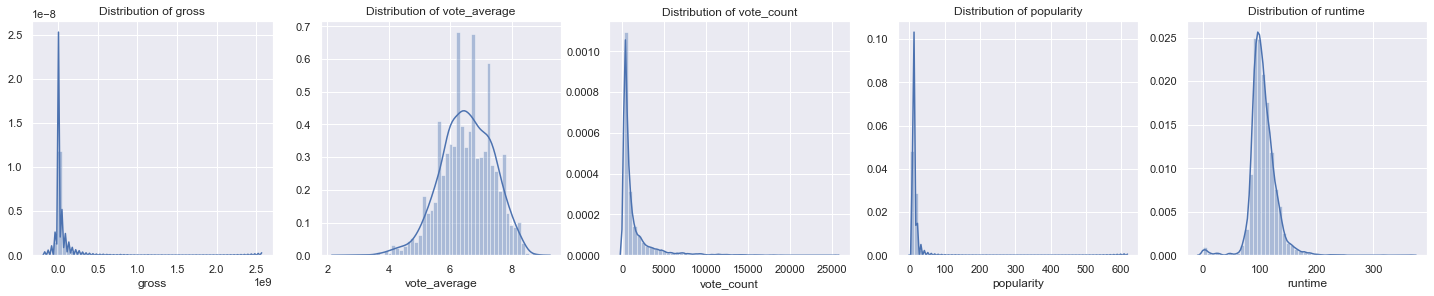

In [37]:
# distribution of revenue , it seems that therea are some outliers
plt.figure(figsize=(25,25))
for i in range(len(var)):
    plt.subplot(5,5,i+1)
    sns.distplot(movie[var[i]])
    plt.title("Distribution of {}".format(var[i]))
plt.show()
# we can see most predictiors contian outliers
# next step will be removing outliers

## remove outliers

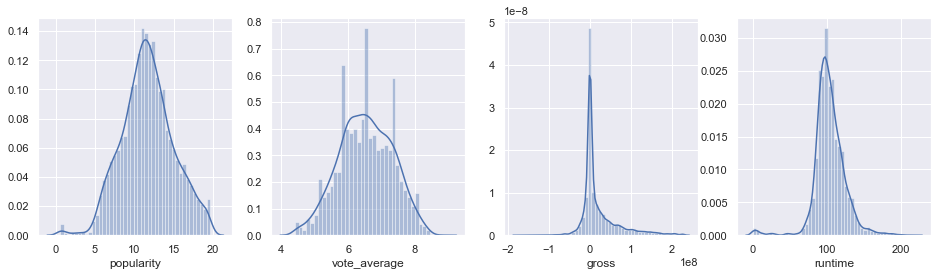

In [38]:
# plot distributions of variavles after removed outliers
plt.figure(figsize=(16,4))
#===========================================================
## remove outliers : popularity 
plt.subplot(1,4,1)
q=movie.popularity.quantile(0.9)
movie1=movie[movie.popularity<q]
sns.distplot(movie1.popularity)
#===========================================================
## remove outliers : vote_average
plt.subplot(1,4,2)
q1=movie1.vote_average.quantile(0.01)
movie2=movie1[movie1.vote_average>q1]
sns.distplot(movie2.vote_average)
#===========================================================
## remove outliers : gross
plt.subplot(1,4,3)
q2=movie2.gross.quantile(0.97)
movie3=movie2[movie2.gross<q2]
sns.distplot(movie3.gross)
#===========================================================
## remove outliers : runtime
plt.subplot(1,4,4)
q3=movie3.runtime.quantile(0.999)
movie4=movie3[movie3.runtime<q3]
sns.distplot(movie4.runtime)

In [40]:
final_movie=movie4.copy() # copy the data 

## Linearity

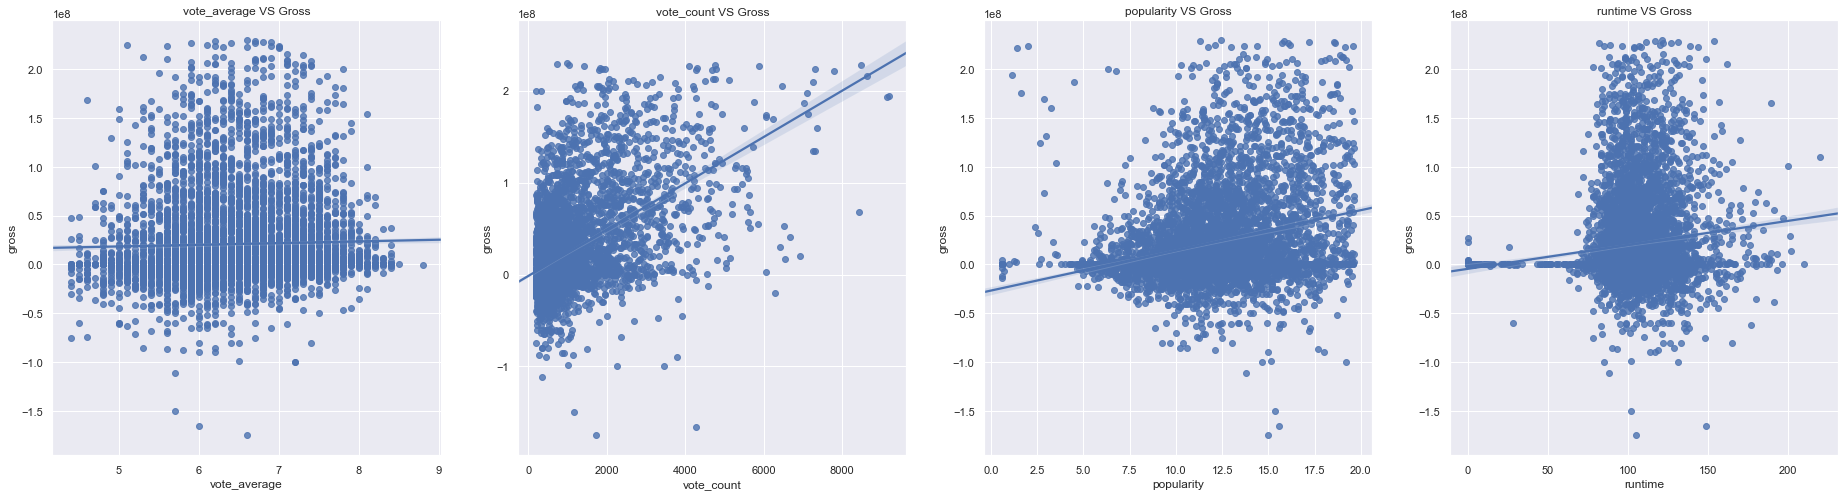

In [1005]:
import seaborn as sns; sns.set(color_codes=True)
var2=['vote_average','vote_count','popularity','runtime']

plt.figure(figsize=(32,8))
for i in range(0,len(var2)):
    plt.subplot(1,4,i+1)
    ax = sns.regplot(x=final_movie[var2[i]], y=final_movie.gross)
    plt.title("{} VS Gross".format(var2[i]))
plt.subplots_adjust(hspace=0.5)
plt.show()

In [1007]:
# add transformed columns
# final_movie['trans_vote_average']=final_movie.vote_average**(1/2)
#Final_movie['trans_vote_count']=final_movie.vote_count**(1/3)
# final_movie['trans_popularity']=final_movie.popularity**(2)
# final_movie['trans_runtime']=final_movie.runtime**(1/2)

In [49]:

feature_col=['vote_average','vote_count','popularity','runtime','Animation', 'Mystery', 'Science Fiction','Crime', 'Action', 'Fantasy', 'Thriller', 'Horror', 'TV Movie',
       'Romance', 'Western', 'History', 'Adventure', 'Comedy', 'Family',
       'Drama', 'War', 'Music']

inputs=movie[feature_col]
target=movie.gross


In [50]:
inputs.to_csv('inputs.csv')
target.to_csv('target.csv')

/Users/yingyuxuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


# Data Engineering and data preprocessing

In [52]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [53]:
# train test split
# use train/test split with different random_state values
X_train, X_test, y_train, y_test = train_test_split(inputs, target, random_state=0)

In [85]:
#Scaled data
# Create a scaler object
scale = StandardScaler()
# transform train data
transformed1 = scale.fit_transform(X_train)
X_train = pd.DataFrame(transformed1, columns = X_train.columns)
# transform test data
transformed2 = scale.transform(X_test)
X_test = pd.DataFrame(transformed2, columns = X_test.columns)

In [86]:
inputs_scaled=scale.fit_transform(inputs)

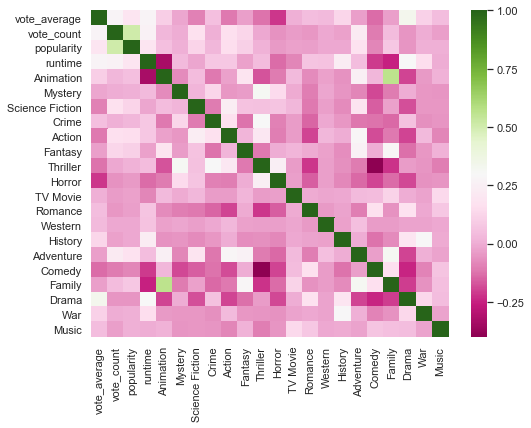

In [87]:
# Feature selection # I like pink color ^-^
plt.figure(figsize=(8,6))
sns.heatmap(X_train.corr(),cmap="PiYG")
plt.show()

# Regular linear regression model

In [88]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [89]:
test_accuracy = reg.score(X_test, y_test)
train_accuracy=reg.score(X_train, y_train)
print("Linear Regression Train Accuracy: {:2f}%".format(train_accuracy*100))
print("Linear Regression test Accuracy: {:2f}%".format(test_accuracy*100 ))

Linear Regression Train Accuracy: 57.315989%
Linear Regression test Accuracy: 58.364840%


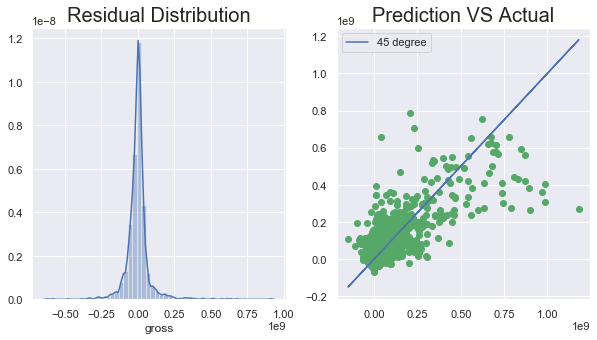

In [90]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
y_test_reg_pred=reg.predict(X_test)
# distribution of residual is 
sns.distplot(y_test-y_test_reg_pred)
plt.title('Residual Distribution',fontsize=20)
plt.subplot(1,2,2)
#plt.scatter(y_test,y_test_reg_pred)
plt.scatter(y_test,y_test_reg_pred,color='g')
plt.plot(y_test,y_test,label='45 degree')
plt.title('Prediction VS Actual',fontsize=20)
plt.legend()
plt.show()

In [91]:
lr_rmse=np.sqrt(mean_squared_error(y_test,y_test_reg_pred))
lr_rmse

83173664.6782986

# Ridge Model

In [111]:
# define the parameter values that should be searched
# given a list of alphas 
alphas=[0.0001,0.005,0.01,0.05,0.1,0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

{'alpha': [0.0001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]}


In [146]:
#Gride search to get optimal alpha which is 0.05
model1 = RidgeCV(alphas=alphas,cv=20, normalize=False)
model1.fit(X_train,y_train) 
print('The optimal alpha for Ridge model: '+str(model1.alpha_))

The optimal alpha for Ridge model: 17.0


In [147]:
model_ridge = Ridge(alpha=model1.alpha_ ,normalize=False)
model_ridge.fit(X_train, y_train)

Ridge(alpha=17.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [148]:
train_score_ridge = model_ridge.score(X_train, y_train)  
test_score_ridge = model_ridge.score(X_test, y_test)  
print("Ridge Regression train Accuracy: {:2f}%".format(train_score_ridge * 100))
print("Ridge Regression test Accuracy: {:2f}%".format(test_score_ridge* 100))

Ridge Regression train Accuracy: 57.315295%
Ridge Regression test Accuracy: 58.333663%


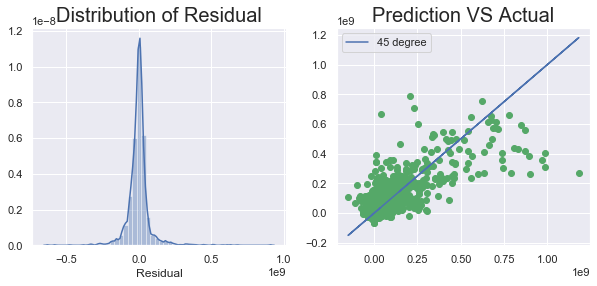

In [149]:
y_test_predict_ridge=model_ridge.predict(X_test)
plt.figure(figsize=(10,4))
# distribution of residual
plt.subplot(1,2,1)
sns.distplot(y_test-y_test_predict_ridge)
plt.title('Distribution of Residual',fontsize=20)
plt.xlabel('Residual')

plt.subplot(1,2,2)
plt.scatter(y_test,y_test_predict_ridge,color='g')
plt.plot(y_test,y_test,label='45 degree')
plt.title('Prediction VS Actual',fontsize=20)
plt.legend()
plt.show()

In [150]:
ridge_rmse=np.sqrt((1/len(y_test))*(sum((y_test-y_test_predict_ridge)**2)))#**(1/2)
ridge_rmse 

83204800.10219151

# Lasso Model

In [151]:
modelasso = LassoCV(alphas=alphas,cv=20,normalize=False)
modelasso.fit(X_train, y_train)

LassoCV(alphas=[0.0001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                10, 11, 12, 13, 14, 15, 16, 17],
        copy_X=True, cv=20, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [152]:
modelasso.alpha_

0.0001

In [153]:
# use the best alpha and fit it into model 
model_lasso = Lasso(alpha=modelasso.alpha_,normalize=False)
model_lasso.fit(X_train, y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [154]:
train_score_lasso = model_lasso.score(X_train, y_train)  
test_score_lasso = model_lasso.score(X_test, y_test) 
print("Lasso Regression test score: {:2f}%".format(test_score_lasso* 100))
print("Lasso Regression train score: {:2f}%".format(train_score_lasso * 100))

Lasso Regression test score: 58.364840%
Lasso Regression train score: 57.315989%


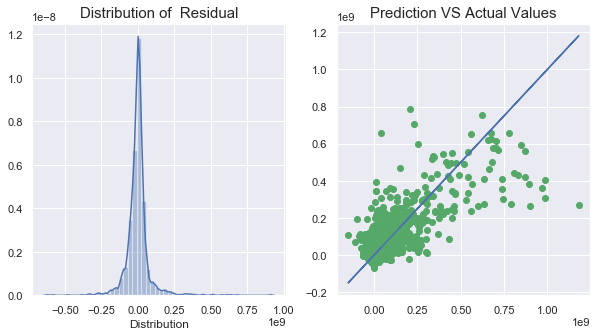

In [155]:
# to get y_test_predict
y_test_predict_lasso=model_lasso.predict(X_test)
# distribution of residual
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(y_test-y_test_predict_lasso)
plt.title('Distribution of  Residual', fontsize=15)
plt.xlabel('Distribution')
plt.subplot(1,2,2)
plt.scatter(y_test,y_test_predict_lasso,color='g')
plt.plot(y_test,y_test)
plt.title('Prediction VS Actual Values',fontsize=15)
plt.show()

In [156]:
lasso_rmse=np.sqrt((1/len(y_test))*(sum((y_test-y_test_predict_lasso)**2)))
lasso_rmse

83173664.67825828

In [157]:
lr_rmse,ridge_rmse,lasso_rmse  # we can see lasso model performs a little bit better

(83173664.6782986, 83204800.10219151, 83173664.67825828)

# Neural NetWork

In [173]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot
from tensorflow.keras import regularizers

In [170]:
input_dim = X_train.shape[1] 

In [211]:
from tensorflow.keras.callbacks import EarlyStopping

EarlyStopping(monitor='val_err', patience=5)
# define model
model = Sequential()
model.add(Dense(20, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(1, activation='linear'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_absolute_error', optimizer=opt,metrics=['accuracy'])
# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100,  batch_size=50,verbose=1)

In [212]:
# evaluate the model
_, train_mse = model.evaluate(X_train, y_train, verbose=0)
_, test_mse = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.090, Test: 0.074


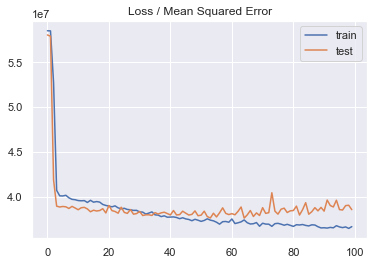

In [190]:
from matplotlib import pyplot
# plot loss during training
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [191]:
#prediction
nn_train_pre=model.predict(X_train)
nn_test_pre=model.predict(X_test)
# Obtian RMSE 
nn_rmse_train = np.sqrt(mean_squared_error(y_train, nn_train_pre))
nn_rmse_test = np.sqrt(mean_squared_error(y_test, nn_test_pre))
print('Train RMSE: %.3f' % nn_rmse_train)
print('Test RMSE: %.3f' % nn_rmse_test)

Train RMSE: 82681677.062
Test RMSE: 79486432.778


In [219]:
nn_pre=[i[0] for i in nn_test_pre]

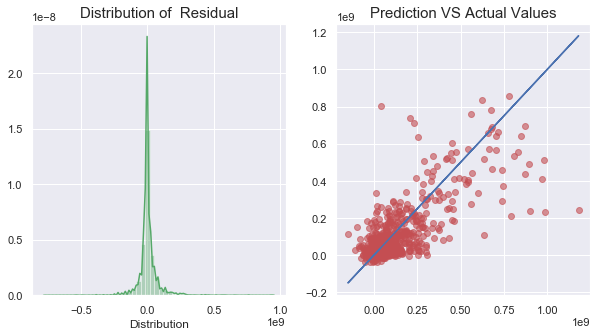

In [227]:
# plt.scatter(y_train, nn_train_pre)
# plt.plot(y_train,y_train)
# plt.title('Prediction VS Actual Values')
# plt.show()


# distribution of residual
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(y_test-nn_pre,color='g')
plt.title('Distribution of  Residual', fontsize=15)
plt.xlabel('Distribution')

plt.subplot(1,2,2)
plt.scatter(y_test, nn_pre,color='r',alpha=0.6)
plt.plot(y_test,y_test)
plt.title('Prediction VS Actual Values',fontsize=15)
plt.show()

In [240]:
# SCORE (R_squared) of Neural Network
ssr=sum((np.array(nn_pre)-y_test.mean())**2)
sst=sum((y_test-y_test.mean())**2)
nn_score=ssr/sst
print("Test score of Neural Network :{}".format(nn_score))

Test score of Neural Network :0.6723058336460455


# Model Evaluation

In [228]:
rmse_list=[lr_rmse,ridge_rmse,lasso_rmse,nn_rmse_test]
model_list=["Linear Regression", "Ridge Regression",'Lasso Regression',' Neural Network']

In [229]:
for rmse in rmse_list:
    if rmse==min(rmse_list):
        index=rmse_list.index(rmse)
        print(" The best model is {} with lowest rmse {}".format(model_list[index],rmse))

 The best model is  Neural Network with lowest rmse 79486432.77755177


In [244]:
print("Linear Regression test score: {:2f}%".format(test_accuracy*100 ))
print("Ridge Regression test score : {:2f}%".format(test_score_ridge* 100))
print("Lasso Regression test score : {:2f}%".format(test_score_lasso* 100))
print("Neural Network test score   : {:2f}%".format(nn_score*100))

Linear Regression test score: 58.364840%
Ridge Regression test score : 58.333663%
Lasso Regression test score : 58.364840%
Neural Network test score   : 67.230583%
